# FashionMNIST

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

Мы будем работать с картинками одежды (чёрно-белыми, 28 на 28). По входной картинке нужно предсказать тип одежды на 10 классов.

In [1]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 21.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.4 MB/s eta 0:00:00


In [2]:
import wandb

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
import os # для логирования

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

In [5]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
  random.seed(seed) #Фиксируем генератор рандомных чисел
  os.environ['PYTHONHASHSEED'] = str(seed) #Хэши
  np.random.seed(seed) #Фиксируем генератор рандомных чисел np
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

Выпишем все классы для последующего использования.

In [6]:
class CFG:

# Задаем параметры нашего эксперимента

  api = ""# вписать свой API Wandb
  project = "home_work"# вписать название эксперимента, который предварительно надо создать в Wandb
  entity = ""# ввести свой логин
  num_epochs = 12 # количество эпох
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 4 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  #classes = # классы датасета
  wandb = False # флаг использования Wandb


In [7]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

Обратим внимание, что датасет поменялся, а значит поменлись среднее и стандартное отклонение, их необходимо посмотреть на официальной страничке датасета [ссылка](https://boscoj2008.github.io/customCNN/).

In [8]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307, ) , (0.3530))])

Загружаем данные.

In [9]:
#Загружаем дату
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_batch_size,
                                            shuffle=True, num_workers=CFG.num_workers, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=CFG.test_batch_size,
                                            shuffle=True, num_workers=CFG.num_workers, pin_memory=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 13761376.49it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 200564.91it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3722320.15it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22398627.59it/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


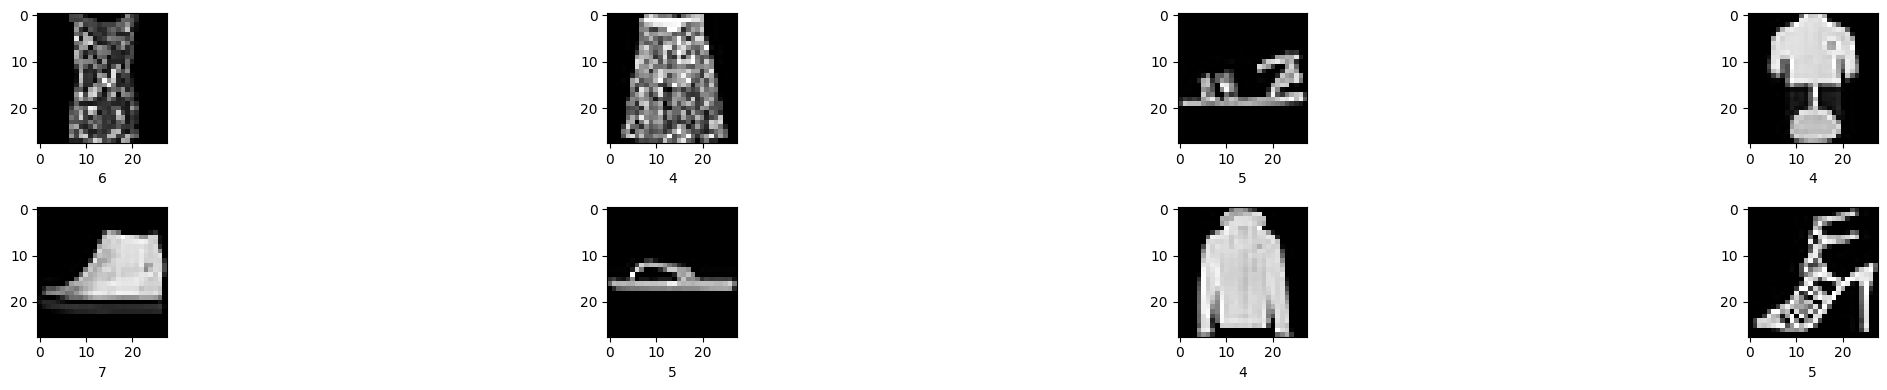

In [10]:
# отрисуем несколько картинок

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for i in np.arange(8):
  plt.subplot(2, 4, i+1)
  plt.tight_layout()
  plt.imshow(images[i][0], cmap='gray')
  plt.xlabel(str(labels[i])[7])


Создаем полносвязаннную нейронную сеть.

In [11]:
class My_Net(nn.Module):
  def __init__(self):
    super(My_Net, self).__init__()
    #Организуем 3 слоя полносвязной сети
    hidden_1 = 512
    hidden_2 = 256
    hidden_3 = 256

    self.net = nn.Sequential(
        nn.Linear(28*28, hidden_1),
        nn.GELU(),
        nn.Linear(hidden_1, hidden_2),
        nn.GELU(),
        nn.Linear(hidden_2, hidden_3),
        nn.GELU(),
        nn.Linear(hidden_3, 10),
        nn.Softmax()
        )

  def forward(self, x):
    x = x.view(-1 , 28*28)
    x = self.net(x)
    return x

In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('CPU')

model = My_Net()
model = model.to(device)# переводим модель на GPU
print(model) # посмотрим на нашу модель

My_Net(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): GELU(approximate='none')
    (6): Linear(in_features=256, out_features=10, bias=True)
    (7): Softmax(dim=None)
  )
)


In [13]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# Adagrad  со скоростью обучения (learning rate) = 0.01
optimizer = torch.optim.Adagrad(params=model.parameters(),
                                lr=CFG.lr)

In [14]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train()# обязательно переводим в режим обучения
    test_loss = 0
    correct = 0

    n_ex = len(train_loader)

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        # обнуляем градиенты!
        optimizer.zero_grad()
        # прямой проход
        output = model.forward(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss = criterion(output, target) # считаем значение функции потерь
        # обратный проход
        train_loss.backward()
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))

    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [15]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval()# переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss=criterion(output, target) # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))

    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [16]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    use_cuda = torch.cuda.is_available()
    # фиксируем сиды
    seed_everything(CFG.seed)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('CPU')

    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

In [17]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Thu Oct  5 16:07:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    26W /  70W |    621MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [18]:
#Первая модель
class My_Net2(nn.Module):
  def __init__(self):
    super(My_Net, self).__init__()
    #Организуем 3 слоя полносвязной сети
    hidden_1 = 512
    hidden_2 = 256
    hidden_3 = 256

    self.net = nn.Sequential(
        nn.Linear(28*28, hidden_1),
        nn.GELU(),
        nn.Linear(hidden_1, hidden_2),
        nn.GELU(),
        nn.Linear(hidden_2, hidden_3),
        nn.GELU(),
        nn.Linear(hidden_3, 10),
        nn.Softmax()
        )

  def forward(self, x):
    x = x.view(-1 , 28*28)
    x = self.net(x)
    return x

In [19]:
main(model)


Epoch: 1


  0%|          | 0/938 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 938/938 [00:19<00:00, 46.96it/s]


Train set: Average loss: 1.6599, Accuracy: 78%


Test set: Average loss: 1.6447, Accuracy: 81%

Epoch: 2


100%|██████████| 938/938 [00:15<00:00, 61.59it/s]


Train set: Average loss: 1.5393, Accuracy: 83%


Test set: Average loss: 1.6376, Accuracy: 83%

Epoch: 3


100%|██████████| 938/938 [00:15<00:00, 61.57it/s]


Train set: Average loss: 1.6117, Accuracy: 84%


Test set: Average loss: 1.6724, Accuracy: 83%

Epoch: 4


100%|██████████| 938/938 [00:16<00:00, 55.85it/s]


Train set: Average loss: 1.6963, Accuracy: 85%


Test set: Average loss: 1.6075, Accuracy: 83%

Epoch: 5


100%|██████████| 938/938 [00:15<00:00, 60.87it/s]


Train set: Average loss: 1.6081, Accuracy: 85%


Test set: Average loss: 1.6276, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:14<00:00, 62.82it/s]


Train set: Average loss: 1.5391, Accuracy: 86%


Test set: Average loss: 1.5606, Accuracy: 84%

Epoch: 7


100%|██████████| 938/938 [00:15<00:00, 62.41it/s]


Train set: Average loss: 1.6111, Accuracy: 86%


Test set: Average loss: 1.6409, Accuracy: 84%

Epoch: 8


100%|██████████| 938/938 [00:15<00:00, 62.20it/s]


Train set: Average loss: 1.6051, Accuracy: 86%


Test set: Average loss: 1.5916, Accuracy: 85%

Epoch: 9


100%|██████████| 938/938 [00:14<00:00, 62.90it/s]


Train set: Average loss: 1.7134, Accuracy: 86%


Test set: Average loss: 1.6002, Accuracy: 85%

Epoch: 10


100%|██████████| 938/938 [00:14<00:00, 63.42it/s]


Train set: Average loss: 1.5643, Accuracy: 86%


Test set: Average loss: 1.6018, Accuracy: 85%

Epoch: 11


100%|██████████| 938/938 [00:14<00:00, 62.61it/s]


Train set: Average loss: 1.6228, Accuracy: 87%


Test set: Average loss: 1.5962, Accuracy: 85%

Epoch: 12


100%|██████████| 938/938 [00:15<00:00, 62.27it/s]


Train set: Average loss: 1.5237, Accuracy: 87%


Test set: Average loss: 1.6120, Accuracy: 85%
Training is end!


Получился посредственный результат


Пробуем другие оптимизаторы.

In [20]:
# Adagrad  со скоростью обучения (learning rate) = 0.01
optimizer = torch.optim.Adam(params=model.parameters(),
                                lr=CFG.lr)

In [21]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:18<00:00, 52.11it/s]



Train set: Average loss: 1.7653, Accuracy: 69%
Test set: Average loss: 1.7516, Accuracy: 64%

Epoch: 2


100%|██████████| 938/938 [00:16<00:00, 55.41it/s]


Train set: Average loss: 1.7424, Accuracy: 70%


Test set: Average loss: 1.7809, Accuracy: 71%

Epoch: 3


100%|██████████| 938/938 [00:14<00:00, 62.58it/s]


Train set: Average loss: 1.7758, Accuracy: 70%


Test set: Average loss: 1.8917, Accuracy: 61%

Epoch: 4


100%|██████████| 938/938 [00:15<00:00, 61.57it/s]


Train set: Average loss: 1.9299, Accuracy: 68%


Test set: Average loss: 1.8692, Accuracy: 58%

Epoch: 5


100%|██████████| 938/938 [00:15<00:00, 62.20it/s]


Train set: Average loss: 1.7737, Accuracy: 69%


Test set: Average loss: 1.8066, Accuracy: 62%

Epoch: 6


100%|██████████| 938/938 [00:20<00:00, 46.10it/s]


Train set: Average loss: 1.7737, Accuracy: 69%


Test set: Average loss: 1.7957, Accuracy: 62%

Epoch: 7


100%|██████████| 938/938 [00:15<00:00, 58.66it/s]


Train set: Average loss: 1.7112, Accuracy: 64%


Test set: Average loss: 1.8803, Accuracy: 60%

Epoch: 8


100%|██████████| 938/938 [00:15<00:00, 62.36it/s]


Train set: Average loss: 1.8362, Accuracy: 65%


Test set: Average loss: 1.8066, Accuracy: 64%

Epoch: 9


100%|██████████| 938/938 [00:15<00:00, 61.88it/s]


Train set: Average loss: 2.0237, Accuracy: 62%


Test set: Average loss: 1.9464, Accuracy: 49%

Epoch: 10


100%|██████████| 938/938 [00:15<00:00, 62.49it/s]


Train set: Average loss: 1.8987, Accuracy: 49%


Test set: Average loss: 1.8288, Accuracy: 64%

Epoch: 11


100%|██████████| 938/938 [00:15<00:00, 61.80it/s]


Train set: Average loss: 1.6487, Accuracy: 64%


Test set: Average loss: 1.7338, Accuracy: 71%

Epoch: 12


100%|██████████| 938/938 [00:16<00:00, 57.79it/s]


Train set: Average loss: 1.7424, Accuracy: 68%


Test set: Average loss: 1.7994, Accuracy: 68%
Training is end!


In [25]:
#Созданим архитектуру сверочной модели
class MyNet3(nn.Module):
  def __init__(self):
    super(MyNet3, self).__init__()

    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
    #Нормируем
    self.norm1 = nn.BatchNorm2d(16)
    #Устанавливаем исхожные веса
    nn.init.xavier_uniform(self.cnn1.weight)
    #Оставляем лишь максимальное значение
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    self.cnn2 = nn.Conv2d(in_channels= 16, out_channels=32, kernel_size=5, stride=1, padding=2)
    #Нормируем
    self.norm2 = nn.BatchNorm2d(32)
    #Устанавливаем исхожные веса
    nn.init.xavier_uniform(self.cnn2.weight)
    #Оставляем лишь максимальное значение
    self.maxpool2 = nn.MaxPool2d(kernel_size=2)

    self.fc1 = nn.Linear(32*7*7, 10)

  def forward(self, x):
    x = self.cnn1(x)
    x = F.relu(x)
    x = self.norm1(x)

    x = self.maxpool1(x)

    x = self.cnn2(x)
    x = F.relu(x)
    x = self.norm2(x)

    x = self.maxpool2(x)

    x = x.view(x.size(0),-1)
    x = self.fc1(x)
    return x


In [26]:
model2 = MyNet3()
model2.to(device)
print(model2)

MyNet3(
  (cnn1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=10, bias=True)
)


<ipython-input-25-49d48bc81ac5>:10: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.cnn1.weight)
<ipython-input-25-49d48bc81ac5>:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.cnn2.weight)


In [27]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# Adam со скоростью обучения (learning rate) = 0.01
optimizer = torch.optim.Adam(params=model2.parameters(),
                                lr=CFG.lr)

In [28]:
main(model2)


Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 938/938 [00:19<00:00, 47.54it/s]


Train set: Average loss: 0.2940, Accuracy: 87%


Test set: Average loss: 0.3000, Accuracy: 87%

Epoch: 2


100%|██████████| 938/938 [00:15<00:00, 59.21it/s]


Train set: Average loss: 0.1324, Accuracy: 90%


Test set: Average loss: 0.3678, Accuracy: 89%

Epoch: 3


100%|██████████| 938/938 [00:15<00:00, 62.22it/s]


Train set: Average loss: 0.1619, Accuracy: 91%


Test set: Average loss: 0.4073, Accuracy: 90%

Epoch: 4


100%|██████████| 938/938 [00:15<00:00, 61.31it/s]


Train set: Average loss: 0.3021, Accuracy: 92%


Test set: Average loss: 0.2087, Accuracy: 90%

Epoch: 5


100%|██████████| 938/938 [00:15<00:00, 61.19it/s]


Train set: Average loss: 0.0436, Accuracy: 93%


Test set: Average loss: 0.3636, Accuracy: 89%

Epoch: 6


100%|██████████| 938/938 [00:15<00:00, 62.03it/s]


Train set: Average loss: 0.1500, Accuracy: 93%


Test set: Average loss: 0.1651, Accuracy: 90%

Epoch: 7


100%|██████████| 938/938 [00:15<00:00, 61.31it/s]


Train set: Average loss: 0.1917, Accuracy: 94%


Test set: Average loss: 0.3511, Accuracy: 91%

Epoch: 8


100%|██████████| 938/938 [00:15<00:00, 62.03it/s]


Train set: Average loss: 0.1351, Accuracy: 94%


Test set: Average loss: 0.2271, Accuracy: 90%

Epoch: 9


100%|██████████| 938/938 [00:15<00:00, 60.26it/s]


Train set: Average loss: 0.1544, Accuracy: 95%


Test set: Average loss: 0.3148, Accuracy: 90%

Epoch: 10


100%|██████████| 938/938 [00:15<00:00, 61.21it/s]


Train set: Average loss: 0.3072, Accuracy: 95%


Test set: Average loss: 0.2560, Accuracy: 91%

Epoch: 11


100%|██████████| 938/938 [00:15<00:00, 61.20it/s]


Train set: Average loss: 0.1619, Accuracy: 95%


Test set: Average loss: 0.2336, Accuracy: 90%

Epoch: 12


100%|██████████| 938/938 [00:15<00:00, 61.12it/s]


Train set: Average loss: 0.0092, Accuracy: 96%


Test set: Average loss: 0.2725, Accuracy: 90%
Training is end!


Мы видим, что после 7 эпохи сеть начала переобучаться. Нам удалось получить 91% точности на тесте, что я считаю успехом